K fold: 10 Folds, 80% training, 20% testing split. (4 HI, 4 NH for testing, and rest for training)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle

# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split'

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

for fold_number in range(1, 11):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)


# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(1, 11),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)


ModuleNotFoundError: No module named 'keras'

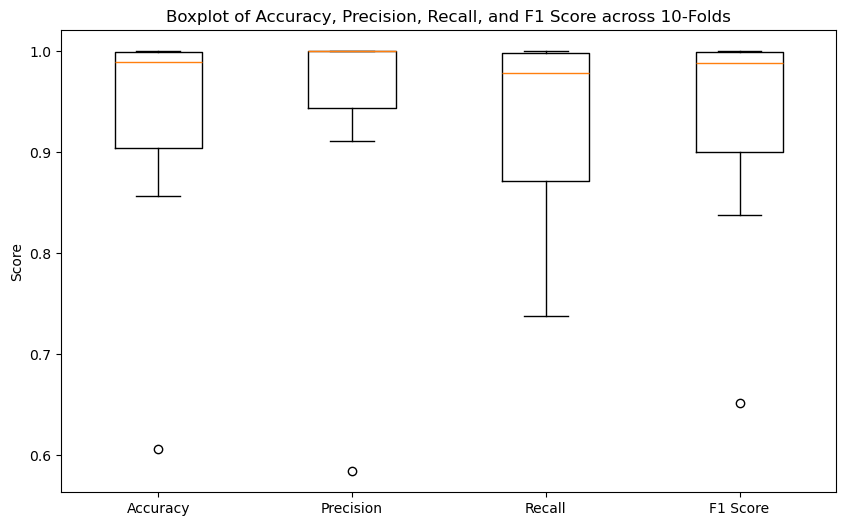

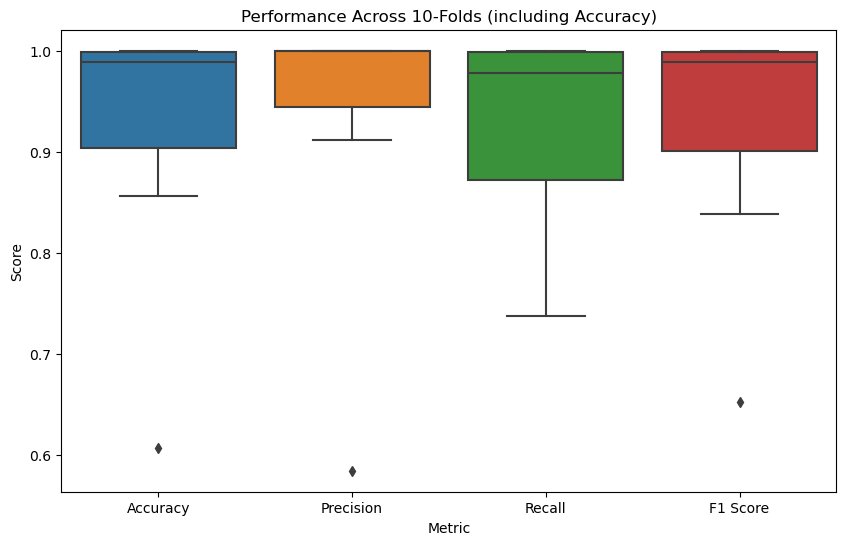


Summary of Results:
           Worst Fold  Avg. Fold  Best Fold
Metric                                     
Accuracy     0.606250   0.924687        1.0
F1 Score     0.651934   0.926927        1.0
Precision    0.584158   0.939400        1.0
Recall       0.737500   0.919375        1.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data
accuracy_list = [0.606250, 0.856250, 0.903125, 0.906250, 1.000000, 0.996875, 0.981250, 1.000000, 0.996875, 1.000000]  # Replace with your actual accuracy values
precision_list = [0.584158, 0.959677, 0.938776, 0.911392, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
recall_list = [0.7375, 0.74375, 0.8625, 0.9, 1.0, 0.99375, 0.9625, 1.0, 0.99375, 1.0]
f1_list = [0.651934, 0.838028, 0.899023, 0.90566, 1.0, 0.996865, 0.980892, 1.0, 0.996865, 1.0]

# Combine the lists into a single list of lists
data = [accuracy_list, precision_list, recall_list, f1_list]  # Include accuracy in the data

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Accuracy', 'Precision', 'Recall', 'F1 Score'])  # Adjust the labels

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Accuracy, Precision, Recall, and F1 Score across 10-Folds')

# Show the plot
plt.show()

# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(1, 11), 4),  # Adjust the repeat value
    'Metric': ['Accuracy'] * 10 + ['Precision'] * 10 + ['Recall'] * 10 + ['F1 Score'] * 10,  # Adjust the categories
    'Score': accuracy_list + precision_list + recall_list + f1_list  # Include accuracy in the scores
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 10-Folds (including Accuracy)')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)


K fold: 5 Folds, 80% training, 20% testing split. (4 HI, 4 NH for testing, and rest for training)

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/5folds- 80-20 train test split'  # Change this to the root folder containing your k-fold data

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

for fold_number in range(1, 6):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

# Traverse through fold_accuracies and print them
print("Accuracies for each fold:")
for fold_number, accuracy in enumerate(fold_accuracies, start=1):
    print(f'Fold {fold_number}: {accuracy}')

average_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f'\nAverage Accuracy across Folds 1-5: {average_accuracy}')
print(f'Standard Deviation of Accuracy across Folds 1-5: {std_accuracy}')


ModuleNotFoundError: No module named 'keras'

1-11-23
This code below is for K fold: 5 folds, 80%-20% train/test split, but it includes evluation metrics, boxplot and summary table 

UPDATE: THIS IS THE ONE FOR 5 FOLD!

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle

# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/5folds- 80-20 train test split'

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

for fold_number in range(1, 6):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)


# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(1, 6),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)

import pickle

# Load the results from the file
with open('evaluation_results.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

# Access individual lists
precision_list_loaded = loaded_results['precision_list']
recall_list_loaded = loaded_results['recall_list']
f1_list_loaded = loaded_results['f1_list']

# Print the loaded results
print("Precision List:", precision_list_loaded)
print("Recall List:", recall_list_loaded)
print("F1 List:", f1_list_loaded)


import matplotlib.pyplot as plt


# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score')

# Show the plot
plt.show()

# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(1, 6), 3),
    'Metric': ['Precision'] * 5 + ['Recall'] * 5 + ['F1 Score'] * 5,
    'Score': precision_list + recall_list + f1_list
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 5-Folds')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)



ModuleNotFoundError: No module named 'keras'

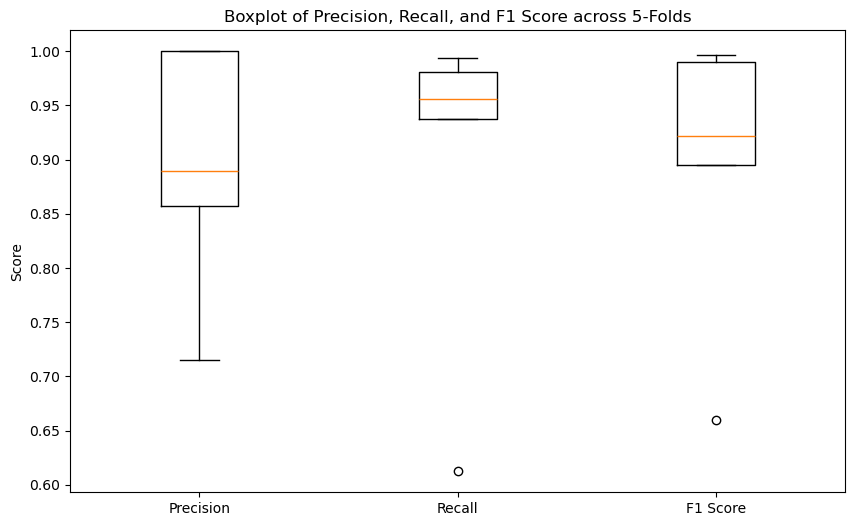

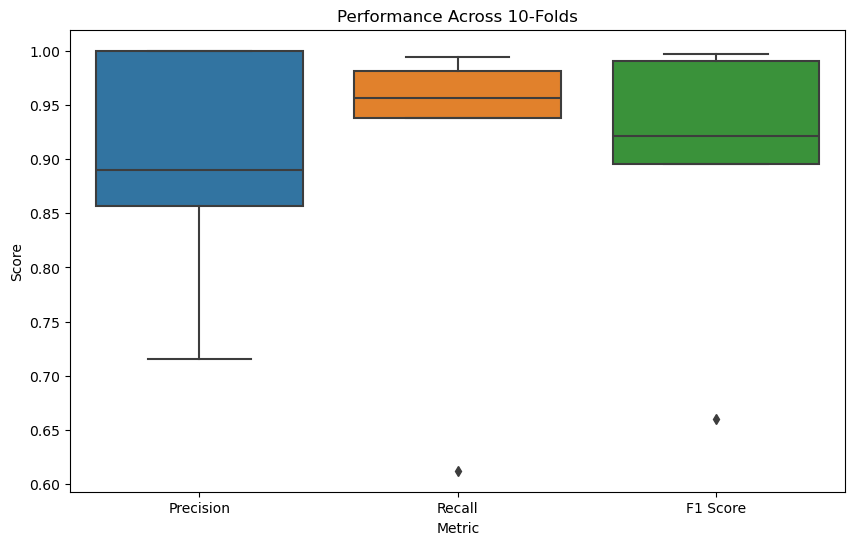


Summary of Results:
           Worst Fold  Avg. Fold  Best Fold
Metric                                     
F1 Score     0.659933   0.892909   0.996865
Precision    0.715328   0.892401   1.000000
Recall       0.612500   0.896250   0.993750


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Data
accuracy_list = [0.684375, 0.890625, 0.918750, 0.990625, 0.996875]  # Replace with your actual accuracy values
precision_list = [0.7153284671532847, 0.8571428571428571, 0.8895348837209303, 1.0, 1.0]
recall_list = [0.6125, 0.9375, 0.95625, 0.98125, 0.99375]
f1_list = [0.6599326599326599, 0.8955223880597014, 0.9216867469879518, 0.9905362776025236, 0.9968652037617556]

# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score across 5-Folds')

# Show the plot
plt.show()
# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(1, 6), 3),
    'Metric': ['Precision'] * 5 + ['Recall'] * 5 + ['F1 Score'] * 5,
    'Score': precision_list + recall_list + f1_list
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 10-Folds')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)

1-13-23:
Save Model Checkpoints:
SCRIPT BELOW CAN BE USED FOR INDEPDENT FOLDS (5 10, ANY)
10 folds INDEPENDENT OF 5 FOLDS
Investigate and implement a mechanism to save model checkpoints during training, ensuring essential information is included.

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle
from keras.models import load_model


# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split'

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

# JUST TRY THIS ON ONE FOLD FIRST
for fold_number in range(1, 11):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Save the model after training
    model.save(f'10fold_model_fold_{fold_number}.h5')

    # Load the saved model for testing
    loaded_model = load_model(f'10fold_model_fold_{fold_number}.h5')

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

     # Save classification results to a file
    results_filename = f'10fold_classification_results_fold_{fold_number}.txt'
    with open(results_filename, 'w') as results_file:
        results_file.write("Image Name\tTrue Label\tPredicted Label\n")
        for i in range(len(test_generator.filenames)):
            image_name = os.path.basename(test_generator.filenames[i])
            true_label = true_labels[i]
            predicted_label = predicted_labels[i]
            results_file.write(f"{image_name}\t{true_label}\t{predicted_label}\n")

# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(1, 10),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)

import pickle

# Load the results from the file
with open('evaluation_results.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

# Access individual lists
precision_list_loaded = loaded_results['precision_list']
recall_list_loaded = loaded_results['recall_list']
f1_list_loaded = loaded_results['f1_list']

# Print the loaded results
print("Precision List:", precision_list_loaded)
print("Recall List:", recall_list_loaded)
print("F1 List:", f1_list_loaded)


# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score')

# Show the plot
plt.show()

# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(1, 11), 3),
    'Metric': ['Precision'] * 10 + ['Recall'] * 10 + ['F1 Score'] * 10,
    'Score': precision_list + recall_list + f1_list
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 5-Folds')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)



ModuleNotFoundError: No module named 'keras'

1-16-23
10 fold based on 5 fold model (dependent training)

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle
from keras.models import load_model


# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split'


# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
# Load the entire model from the file
model = load_model('/home/wangg/REU-Hearing-Loss-Project-1/machine learning/checkpoint results/10 folds 80_20 split/dependentModel/model/10fold_model_fold_5.h5')


# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

# JUST TRY THIS ON ONE FOLD FIRST
for fold_number in range(6, 11):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Save the model after training
    model.save(f'10fold_model_fold_{fold_number}.h5')

    # Load the saved model for testing
    loaded_model = load_model(f'10fold_model_fold_{fold_number}.h5')

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

     # Save classification results to a file
    results_filename = f'10fold_classification_results_fold_{fold_number}.txt'
    with open(results_filename, 'w') as results_file:
        results_file.write("Image Name\tTrue Label\tPredicted Label\n")
        for i in range(len(test_generator.filenames)):
            image_name = os.path.basename(test_generator.filenames[i])
            true_label = true_labels[i]
            predicted_label = predicted_labels[i]
            results_file.write(f"{image_name}\t{true_label}\t{predicted_label}\n")

# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(1, 11),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)

import pickle

# Load the results from the file
with open('evaluation_results.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

# Access individual lists
precision_list_loaded = loaded_results['precision_list']
recall_list_loaded = loaded_results['recall_list']
f1_list_loaded = loaded_results['f1_list']

# Print the loaded results
print("Precision List:", precision_list_loaded)
print("Recall List:", recall_list_loaded)
print("F1 List:", f1_list_loaded)


# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score')

# Show the plot
plt.show()

# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(6, 11), 3),
    'Metric': ['Precision'] * 10 + ['Recall'] * 10 + ['F1 Score'] * 10,
    'Score': precision_list + recall_list + f1_list
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 5-Folds')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)



ModuleNotFoundError: No module named 'keras'

In [8]:
import os

# Print the current working directory
print("Current Working Directory:", os.getcwd())
print("Results File Location:", os.path.abspath(results_filename))


Current Working Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning


NameError: name 'results_filename' is not defined

K fold: 10 Folds, 90% training, 10% testing split. (2 HI, 2 NH for testing, and rest for training)

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 90-10 train test split'  # Change this to the root folder containing your k-fold data

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []

for fold_number in range(1, 11):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

# Traverse through fold_accuracies and print them
print("Accuracies for each fold:")
for fold_number, accuracy in enumerate(fold_accuracies, start=1):
    print(f'Fold {fold_number}: {accuracy}')

average_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f'\nAverage Accuracy across Folds 1-5: {average_accuracy}')
print(f'Standard Deviation of Accuracy across Folds 1-5: {std_accuracy}')


ModuleNotFoundError: No module named 'keras'

In [10]:

# Traverse through fold_accuracies and print them
print("Accuracies for each fold:")
for fold_number, accuracy in enumerate(fold_accuracies, start=1):
    print(f'Fold {fold_number}: {accuracy}')

average_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f'\nAverage Accuracy across Folds 1-10: {average_accuracy}')
print(f'Standard Deviation of Accuracy across Folds 1-10: {std_accuracy}')


Accuracies for each fold:


NameError: name 'fold_accuracies' is not defined

K fold for all subjects (10 fold): EACH FOLD MODEL SHOULD BE INDEPENDENT OF EACH OTHER

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 128)     

2024-01-23 17:17:21.805484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 26s 553ms/step - loss: 0.8773 - accuracy: 0.6285
Epoch 2/60
45/45 [==============================] - 26s 582ms/step - loss: 0.6276 - accuracy: 0.7104
Epoch 3/60
45/45 [==============================] - 25s 543ms/step - loss: 0.5587 - accuracy: 0.7528
Epoch 4/60
45/45 [==============================] - 26s 568ms/step - loss: 0.5365 - accuracy: 0.7729
Epoch 5/60
45/45 [==============================] - 27s 584ms/step - loss: 0.5590 - accuracy: 0.7556
Epoch 6/60
45/45 [==============================] - 25s 546ms/step - loss: 0.5222 - accuracy: 0.7549
Epoch 7/60
45/45 [==============================] - 26s 576ms/step - loss: 0.5042 - accuracy: 0.7854
Epoch 8/60
45/45 [==============================] - 25s 554ms/step - loss: 0.4487 - accuracy: 0.8174
Epoch 9/60
45/45 [==============================] - 25s 557ms/step - loss: 0.4351 - accuracy: 0.8250
Epoch 10/60
45/45 [==============================] - 26s 567ms/step - loss: 0.3830 - accuracy: 0.8521


2024-01-23 17:45:23.413471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 248ms/step - loss: 2.1279 - accuracy: 0.6875

Evaluation for Fold 1:
Test Loss: 2.1279146671295166
Test Accuracy: 0.6875


2024-01-23 17:45:27.008757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 244ms/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 

2024-01-23 17:45:34.055155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 28s 577ms/step - loss: 1.0014 - accuracy: 0.6118
Epoch 2/60
45/45 [==============================] - 25s 555ms/step - loss: 0.6255 - accuracy: 0.7208
Epoch 3/60
45/45 [==============================] - 27s 581ms/step - loss: 0.5636 - accuracy: 0.7535
Epoch 4/60
45/45 [==============================] - 24s 528ms/step - loss: 0.5190 - accuracy: 0.7875
Epoch 5/60
45/45 [==============================] - 21s 464ms/step - loss: 0.4926 - accuracy: 0.8007
Epoch 6/60
45/45 [==============================] - 27s 603ms/step - loss: 0.4843 - accuracy: 0.7910
Epoch 7/60
45/45 [==============================] - 25s 546ms/step - loss: 0.3952 - accuracy: 0.8514
Epoch 8/60
45/45 [==============================] - 25s 547ms/step - loss: 0.3993 - accuracy: 0.8514
Epoch 9/60
45/45 [==============================] - 24s 532ms/step - loss: 0.3374 - accuracy: 0.8799
Epoch 10/60
45/45 [==============================] - 25s 547ms/step - loss: 0.3266 - accuracy: 0.8854


2024-01-23 18:15:27.438823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 254ms/step - loss: 1.8745 - accuracy: 0.6719

Evaluation for Fold 2:
Test Loss: 1.8744878768920898
Test Accuracy: 0.671875


2024-01-23 18:15:30.727929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 236ms/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 

2024-01-23 18:15:34.942288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 28s 582ms/step - loss: 1.4141 - accuracy: 0.5243
Epoch 2/60
45/45 [==============================] - 41s 902ms/step - loss: 0.7034 - accuracy: 0.6556
Epoch 3/60
45/45 [==============================] - 41s 896ms/step - loss: 0.6322 - accuracy: 0.7229
Epoch 4/60
45/45 [==============================] - 40s 891ms/step - loss: 0.6364 - accuracy: 0.7083
Epoch 5/60
45/45 [==============================] - 35s 763ms/step - loss: 0.5490 - accuracy: 0.7694
Epoch 6/60
45/45 [==============================] - 31s 693ms/step - loss: 0.5417 - accuracy: 0.7646
Epoch 7/60
45/45 [==============================] - 41s 907ms/step - loss: 0.5068 - accuracy: 0.7910
Epoch 8/60
45/45 [==============================] - 40s 886ms/step - loss: 0.4888 - accuracy: 0.7861
Epoch 9/60
45/45 [==============================] - 42s 933ms/step - loss: 0.4566 - accuracy: 0.8056
Epoch 10/60
45/45 [==============================] - 41s 895ms/step - loss: 0.4468 - accuracy: 0.8160


2024-01-23 18:57:23.137350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 248ms/step - loss: 3.4488 - accuracy: 0.4969

Evaluation for Fold 3:
Test Loss: 3.4488441944122314
Test Accuracy: 0.49687498807907104


2024-01-23 18:57:26.346296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 250ms/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 

2024-01-23 18:57:33.039020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 28s 600ms/step - loss: 1.0828 - accuracy: 0.5542
Epoch 2/60
45/45 [==============================] - 27s 593ms/step - loss: 0.6943 - accuracy: 0.6417
Epoch 3/60
45/45 [==============================] - 27s 602ms/step - loss: 0.6065 - accuracy: 0.7125
Epoch 4/60
45/45 [==============================] - 27s 590ms/step - loss: 0.5520 - accuracy: 0.7514
Epoch 5/60
45/45 [==============================] - 27s 593ms/step - loss: 0.5074 - accuracy: 0.7701
Epoch 6/60
45/45 [==============================] - 28s 607ms/step - loss: 0.4944 - accuracy: 0.7819
Epoch 7/60
45/45 [==============================] - 27s 598ms/step - loss: 0.4133 - accuracy: 0.8299
Epoch 8/60
45/45 [==============================] - 27s 591ms/step - loss: 0.4006 - accuracy: 0.8215
Epoch 9/60
45/45 [==============================] - 28s 623ms/step - loss: 0.3848 - accuracy: 0.8361
Epoch 10/60
45/45 [==============================] - 27s 593ms/step - loss: 0.3390 - accuracy: 0.8667


2024-01-23 19:29:01.728168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 244ms/step - loss: 4.2340 - accuracy: 0.4656

Evaluation for Fold 4:
Test Loss: 4.234042644500732
Test Accuracy: 0.46562498807907104


2024-01-23 19:29:05.199233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 260ms/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 

2024-01-23 19:29:09.428040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 30s 626ms/step - loss: 1.0416 - accuracy: 0.5792
Epoch 2/60
45/45 [==============================] - 27s 602ms/step - loss: 0.6831 - accuracy: 0.6687
Epoch 3/60
45/45 [==============================] - 18s 400ms/step - loss: 0.6230 - accuracy: 0.7090
Epoch 4/60
45/45 [==============================] - 17s 381ms/step - loss: 0.5692 - accuracy: 0.7569
Epoch 5/60
45/45 [==============================] - 24s 538ms/step - loss: 0.5283 - accuracy: 0.7681
Epoch 6/60
45/45 [==============================] - 29s 630ms/step - loss: 0.5051 - accuracy: 0.7694
Epoch 7/60
45/45 [==============================] - 28s 610ms/step - loss: 0.4386 - accuracy: 0.8243
Epoch 8/60
45/45 [==============================] - 28s 619ms/step - loss: 0.4069 - accuracy: 0.8396
Epoch 9/60
45/45 [==============================] - 27s 606ms/step - loss: 0.3649 - accuracy: 0.8528
Epoch 10/60
45/45 [==============================] - 28s 610ms/step - loss: 0.3513 - accuracy: 0.8736


2024-01-23 20:02:12.084235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 293ms/step - loss: 3.2392 - accuracy: 0.5750

Evaluation for Fold 5:
Test Loss: 3.239222764968872
Test Accuracy: 0.574999988079071


2024-01-23 20:02:15.644584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 248ms/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 

2024-01-23 20:02:19.542142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 27s 557ms/step - loss: 1.0843 - accuracy: 0.6097
Epoch 2/60
45/45 [==============================] - 27s 591ms/step - loss: 0.6795 - accuracy: 0.6722
Epoch 3/60
45/45 [==============================] - 37s 812ms/step - loss: 0.5760 - accuracy: 0.7507
Epoch 4/60
45/45 [==============================] - 37s 824ms/step - loss: 0.5574 - accuracy: 0.7403
Epoch 5/60
45/45 [==============================] - 38s 834ms/step - loss: 0.5176 - accuracy: 0.7708
Epoch 6/60
45/45 [==============================] - 32s 707ms/step - loss: 0.4863 - accuracy: 0.7993
Epoch 7/60
45/45 [==============================] - 30s 670ms/step - loss: 0.4958 - accuracy: 0.7958
Epoch 8/60
45/45 [==============================] - 38s 851ms/step - loss: 0.4665 - accuracy: 0.8076
Epoch 9/60
45/45 [==============================] - 38s 830ms/step - loss: 0.3971 - accuracy: 0.8486
Epoch 10/60
45/45 [==============================] - 41s 906ms/step - loss: 0.3856 - accuracy: 0.8535


2024-01-23 20:39:58.325119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 220ms/step - loss: 3.2944 - accuracy: 0.4719

Evaluation for Fold 6:
Test Loss: 3.2944271564483643
Test Accuracy: 0.47187501192092896


2024-01-23 20:40:01.423211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 245ms/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 

2024-01-23 20:40:05.941145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 31s 643ms/step - loss: 1.1989 - accuracy: 0.5451
Epoch 2/60
45/45 [==============================] - 33s 729ms/step - loss: 0.6821 - accuracy: 0.6514
Epoch 3/60
45/45 [==============================] - 26s 564ms/step - loss: 0.6307 - accuracy: 0.7028
Epoch 4/60
45/45 [==============================] - 34s 759ms/step - loss: 0.5879 - accuracy: 0.7278
Epoch 5/60
45/45 [==============================] - 40s 884ms/step - loss: 0.5324 - accuracy: 0.7688
Epoch 6/60
45/45 [==============================] - 38s 849ms/step - loss: 0.5168 - accuracy: 0.7764
Epoch 7/60
45/45 [==============================] - 29s 639ms/step - loss: 0.4908 - accuracy: 0.7965
Epoch 8/60
45/45 [==============================] - 32s 700ms/step - loss: 0.4501 - accuracy: 0.8160
Epoch 9/60
45/45 [==============================] - 39s 867ms/step - loss: 0.3947 - accuracy: 0.8528
Epoch 10/60
45/45 [==============================] - 39s 867ms/step - loss: 0.3560 - accuracy: 0.8694


2024-01-23 21:17:12.663832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 257ms/step - loss: 3.1181 - accuracy: 0.5750

Evaluation for Fold 7:
Test Loss: 3.118143320083618
Test Accuracy: 0.574999988079071


2024-01-23 21:17:16.295434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 231ms/step
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                

2024-01-23 21:17:21.265084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 36s 754ms/step - loss: 1.0183 - accuracy: 0.5924
Epoch 2/60
45/45 [==============================] - 37s 822ms/step - loss: 0.6174 - accuracy: 0.7361
Epoch 3/60
45/45 [==============================] - 38s 832ms/step - loss: 0.5688 - accuracy: 0.7660
Epoch 4/60
45/45 [==============================] - 25s 549ms/step - loss: 0.5106 - accuracy: 0.7840
Epoch 5/60
45/45 [==============================] - 33s 717ms/step - loss: 0.4765 - accuracy: 0.8097
Epoch 6/60
45/45 [==============================] - 35s 784ms/step - loss: 0.4965 - accuracy: 0.7965
Epoch 7/60
45/45 [==============================] - 38s 838ms/step - loss: 0.4327 - accuracy: 0.8285
Epoch 8/60
45/45 [==============================] - 38s 847ms/step - loss: 0.3997 - accuracy: 0.8389
Epoch 9/60
45/45 [==============================] - 37s 816ms/step - loss: 0.3665 - accuracy: 0.8715
Epoch 10/60
45/45 [==============================] - 36s 787ms/step - loss: 0.3836 - accuracy: 0.8514


2024-01-23 21:53:50.068656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 244ms/step - loss: 5.5999 - accuracy: 0.4125

Evaluation for Fold 8:
Test Loss: 5.59986686706543
Test Accuracy: 0.4124999940395355


2024-01-23 21:53:53.383204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 266ms/step
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                

2024-01-23 21:54:00.150812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 30s 642ms/step - loss: 1.2239 - accuracy: 0.5965
Epoch 2/60
45/45 [==============================] - 30s 657ms/step - loss: 0.6574 - accuracy: 0.6972
Epoch 3/60
45/45 [==============================] - 29s 638ms/step - loss: 0.6074 - accuracy: 0.7326
Epoch 4/60
45/45 [==============================] - 29s 643ms/step - loss: 0.5491 - accuracy: 0.7569
Epoch 5/60
45/45 [==============================] - 29s 641ms/step - loss: 0.5289 - accuracy: 0.7861
Epoch 6/60
45/45 [==============================] - 29s 651ms/step - loss: 0.5163 - accuracy: 0.7701
Epoch 7/60
45/45 [==============================] - 29s 638ms/step - loss: 0.4630 - accuracy: 0.8229
Epoch 8/60
45/45 [==============================] - 29s 643ms/step - loss: 0.5061 - accuracy: 0.7979
Epoch 9/60
45/45 [==============================] - 29s 639ms/step - loss: 0.3891 - accuracy: 0.8625
Epoch 10/60
45/45 [==============================] - 29s 650ms/step - loss: 0.3604 - accuracy: 0.8736


2024-01-23 22:26:55.769837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 240ms/step - loss: 1.6550 - accuracy: 0.6656

Evaluation for Fold 9:
Test Loss: 1.6549642086029053
Test Accuracy: 0.6656249761581421


2024-01-23 22:26:58.949059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 245ms/step
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                

2024-01-23 22:27:03.318387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 29s 606ms/step - loss: 1.0914 - accuracy: 0.5833
Epoch 2/60
45/45 [==============================] - 28s 609ms/step - loss: 0.6571 - accuracy: 0.6896
Epoch 3/60
45/45 [==============================] - 28s 623ms/step - loss: 0.6172 - accuracy: 0.7194
Epoch 4/60
45/45 [==============================] - 28s 618ms/step - loss: 0.5593 - accuracy: 0.7549
Epoch 5/60
45/45 [==============================] - 27s 600ms/step - loss: 0.5478 - accuracy: 0.7528
Epoch 6/60
45/45 [==============================] - 28s 618ms/step - loss: 0.4797 - accuracy: 0.7965
Epoch 7/60
45/45 [==============================] - 27s 588ms/step - loss: 0.4724 - accuracy: 0.8090
Epoch 8/60
45/45 [==============================] - 27s 607ms/step - loss: 0.4502 - accuracy: 0.8188
Epoch 9/60
45/45 [==============================] - 28s 623ms/step - loss: 0.4075 - accuracy: 0.8361
Epoch 10/60
45/45 [==============================] - 27s 592ms/step - loss: 0.4021 - accuracy: 0.8410


2024-01-23 22:59:30.159960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 235ms/step - loss: 2.1880 - accuracy: 0.5281

Evaluation for Fold 10:
Test Loss: 2.188023090362549
Test Accuracy: 0.528124988079071


2024-01-23 22:59:33.353608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 266ms/step


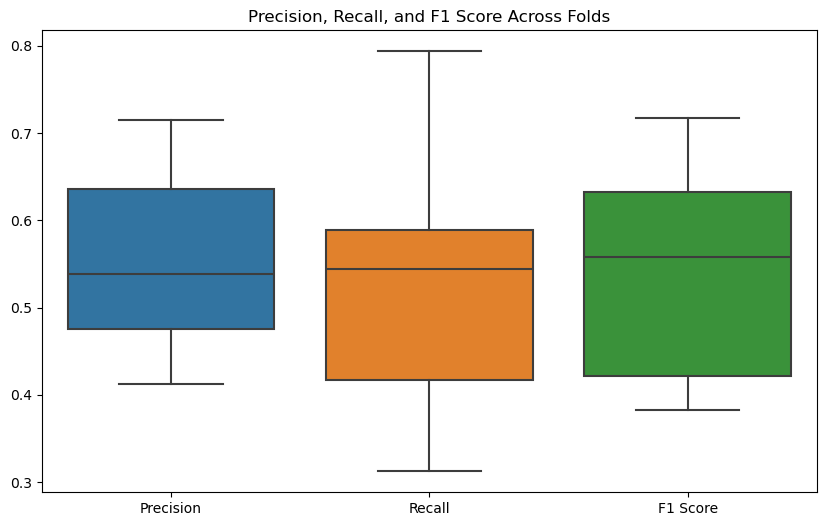

ValueError: All arrays must be of the same length

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle
from keras.models import load_model
from keras.optimizers import Adam
from keras.regularizers import l2


# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)'

# CNN Model
def build_model(input_shape, learning_rate = 0.001):
    # model = Sequential()
    # model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    # model.add(MaxPooling2D((2, 2)))
    # model.add(Conv2D(64, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))
    # model.add(Conv2D(128, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))
    # model.add(Flatten())
    # model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(2, activation='softmax'))
    # optimizer = Adam(learning_rate=learning_rate)
    # model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    # return model

    # apply weight decay
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.0001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# # Create the CNN model
# model = build_model(input_shape)
# model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

for fold_number in range(1, 11):
    # Create the CNN model
    model = build_model(input_shape, learning_rate=0.001)
    model.summary()
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Save the model after training
    model.save(f'10fold_model_fold_{fold_number}.h5')

    # Load the saved model for testing
    loaded_model = load_model(f'10fold_model_fold_{fold_number}.h5')

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

     # Save classification results to a file
    results_filename = f'10fold_classification_results_fold_{fold_number}.txt'
    with open(results_filename, 'w') as results_file:
        results_file.write("Image Name\tTrue Label\tPredicted Label\n")
        for i in range(len(test_generator.filenames)):
            image_name = os.path.basename(test_generator.filenames[i])
            true_label = true_labels[i]
            predicted_label = predicted_labels[i]
            results_file.write(f"{image_name}\t{true_label}\t{predicted_label}\n")

# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(1, 10),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)

import pickle

# Load the results from the file
with open('evaluation_results.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

# Access individual lists
precision_list_loaded = loaded_results['precision_list']
recall_list_loaded = loaded_results['recall_list']
f1_list_loaded = loaded_results['f1_list']

# Print the loaded results
print("Precision List:", precision_list_loaded)
print("Recall List:", recall_list_loaded)
print("F1 List:", f1_list_loaded)


# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score')

# Show the plot
plt.show()

# # Create a DataFrame for easy summary and visualization
# df_results = pd.DataFrame({
#     'Fold': np.repeat(range(1, 11), 3),
#     'Metric': ['Precision'] * 10 + ['Recall'] * 10 + ['F1 Score'] * 10,
#     'Score': precision_list + recall_list + f1_list
# })

# # Visualize the results with a single boxplot
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='Metric', y='Score', data=df_results)
# plt.title('Performance Across 5-Folds')
# plt.show()

# # Summary table
# summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
# summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
# print("\nSummary of Results:")
# print(summary_table)



In [12]:
# Given values
fold_accuracies = [0.715624988079071, 0.6312500238418579, 0.550000011920929, 0.4593749940395355,
                   0.534375011920929, 0.46562498807907104, 0.6000000238418579, 0.4437499940395355,
                   0.668749988079071, 0.659375011920929]

# Calculate the average
average_accuracy = sum(fold_accuracies) / len(fold_accuracies)

# Print the result
print("Average Accuracy:", average_accuracy)


Average Accuracy: 0.5728125035762787


same as above but adding data augmentaiton

2024-01-24 21:01:03.589378: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-24 21:01:04.760347: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

2024-01-24 21:01:05.657149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 43s 940ms/step - loss: 1.2596 - accuracy: 0.5118
Epoch 2/60
45/45 [==============================] - 66s 1s/step - loss: 0.7688 - accuracy: 0.4868
Epoch 3/60
45/45 [==============================] - 109s 2s/step - loss: 0.7519 - accuracy: 0.5153
Epoch 4/60
45/45 [==============================] - 105s 2s/step - loss: 0.7372 - accuracy: 0.5458
Epoch 5/60
45/45 [==============================] - 99s 2s/step - loss: 0.7312 - accuracy: 0.5514
Epoch 6/60
45/45 [==============================] - 100s 2s/step - loss: 0.7254 - accuracy: 0.5535
Epoch 7/60
45/45 [==============================] - 101s 2s/step - loss: 0.7165 - accuracy: 0.5549
Epoch 8/60
45/45 [==============================] - 97s 2s/step - loss: 0.7144 - accuracy: 0.5493
Epoch 9/60
45/45 [==============================] - 101s 2s/step - loss: 0.7182 - accuracy: 0.5431
Epoch 10/60
45/45 [==============================] - 97s 2s/step - loss: 0.7085 - accuracy: 0.5681
Epoch 11/60
45/45 [===

2024-01-24 22:54:22.259228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 5s 367ms/step - loss: 0.7839 - accuracy: 0.5250

Evaluation for Fold 7:
Test Loss: 0.7839160561561584
Test Accuracy: 0.5249999761581421


2024-01-24 22:54:28.895079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 5s 388ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 

2024-01-24 22:54:38.202809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 102s 2s/step - loss: 1.3908 - accuracy: 0.4986
Epoch 2/60
45/45 [==============================] - 101s 2s/step - loss: 0.7652 - accuracy: 0.5556
Epoch 3/60
45/45 [==============================] - 101s 2s/step - loss: 0.7455 - accuracy: 0.5562
Epoch 4/60
45/45 [==============================] - 100s 2s/step - loss: 0.7364 - accuracy: 0.5944
Epoch 5/60
45/45 [==============================] - 83s 2s/step - loss: 0.7286 - accuracy: 0.5875
Epoch 6/60
45/45 [==============================] - 76s 2s/step - loss: 0.7325 - accuracy: 0.5854
Epoch 7/60
45/45 [==============================] - 96s 2s/step - loss: 0.7299 - accuracy: 0.5542
Epoch 8/60
45/45 [==============================] - 95s 2s/step - loss: 0.7101 - accuracy: 0.6153
Epoch 9/60
45/45 [==============================] - 99s 2s/step - loss: 0.7042 - accuracy: 0.5979
Epoch 10/60
45/45 [==============================] - 100s 2s/step - loss: 0.7103 - accuracy: 0.5958
Epoch 11/60
45/45 [======

2024-01-25 00:51:15.847321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 4s 351ms/step - loss: 0.9348 - accuracy: 0.4906

Evaluation for Fold 8:
Test Loss: 0.9348075985908508
Test Accuracy: 0.4906249940395355


2024-01-25 00:51:20.547871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 4s 345ms/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 

2024-01-25 00:51:27.636088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 102s 2s/step - loss: 1.4718 - accuracy: 0.5090
Epoch 2/60
45/45 [==============================] - 103s 2s/step - loss: 0.7685 - accuracy: 0.4979
Epoch 3/60
45/45 [==============================] - 107s 2s/step - loss: 0.7503 - accuracy: 0.5549
Epoch 4/60
45/45 [==============================] - 98s 2s/step - loss: 0.7457 - accuracy: 0.5500
Epoch 5/60
45/45 [==============================] - 96s 2s/step - loss: 0.7369 - accuracy: 0.5014
Epoch 6/60
45/45 [==============================] - 105s 2s/step - loss: 0.7307 - accuracy: 0.4903
Epoch 7/60
45/45 [==============================] - 101s 2s/step - loss: 0.7263 - accuracy: 0.4736
Epoch 8/60
45/45 [==============================] - 101s 2s/step - loss: 0.7236 - accuracy: 0.4854
Epoch 9/60
45/45 [==============================] - 103s 2s/step - loss: 0.7202 - accuracy: 0.5111
Epoch 10/60
45/45 [==============================] - 55s 1s/step - loss: 0.7181 - accuracy: 0.4896
Epoch 11/60
45/45 [====

2024-01-25 02:50:40.889199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 5s 413ms/step - loss: 0.6876 - accuracy: 0.5500

Evaluation for Fold 9:
Test Loss: 0.6876058578491211
Test Accuracy: 0.550000011920929


2024-01-25 02:50:46.498242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 5s 379ms/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 

2024-01-25 02:50:56.286270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 107s 2s/step - loss: 1.4615 - accuracy: 0.5111
Epoch 2/60
45/45 [==============================] - 96s 2s/step - loss: 0.7817 - accuracy: 0.5097
Epoch 3/60
45/45 [==============================] - 107s 2s/step - loss: 0.7646 - accuracy: 0.5347
Epoch 4/60
45/45 [==============================] - 90s 2s/step - loss: 0.7534 - accuracy: 0.5326
Epoch 5/60
45/45 [==============================] - 105s 2s/step - loss: 0.7396 - accuracy: 0.5569
Epoch 6/60
45/45 [==============================] - 106s 2s/step - loss: 0.7330 - accuracy: 0.5556
Epoch 7/60
45/45 [==============================] - 104s 2s/step - loss: 0.7278 - accuracy: 0.5576
Epoch 8/60
45/45 [==============================] - 106s 2s/step - loss: 0.7175 - accuracy: 0.5694
Epoch 9/60
45/45 [==============================] - 77s 2s/step - loss: 0.7179 - accuracy: 0.5576
Epoch 10/60
45/45 [==============================] - 95s 2s/step - loss: 0.7115 - accuracy: 0.5708
Epoch 11/60
45/45 [=====

2024-01-25 04:50:19.823328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 5s 345ms/step - loss: 0.7368 - accuracy: 0.5562

Evaluation for Fold 10:
Test Loss: 0.7367757558822632
Test Accuracy: 0.5562499761581421


2024-01-25 04:50:25.170720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 4s 380ms/step


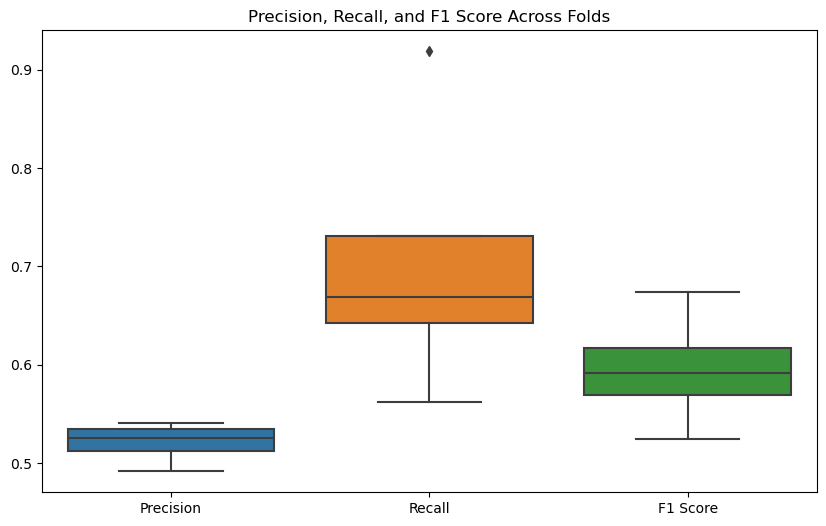

ValueError: All arrays must be of the same length

In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle
from keras.models import load_model
from keras.optimizers import Adam
from keras.regularizers import l2


# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)'

# CNN Model
def build_model(input_shape, learning_rate = 0.001):
    # apply weight decay
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.0001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# # Create the CNN model
# model = build_model(input_shape)
# model.summary()

# # Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)
# Data generator for training with augmentation
train_data_generator = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

for fold_number in range(7, 11):
    # Create the CNN model
    model = build_model(input_shape, learning_rate=0.001)
    model.summary()
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    # Training data with augmentation
    train_generator = train_data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical'
    )


    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    # Training the model with augmented data
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60
    )

    # Save the model after training
    model.save(f'10fold_model_fold_DataAugment_{fold_number}.h5')

    # Load the saved model for testing
    loaded_model = load_model(f'10fold_model_fold_DataAugment_{fold_number}.h5')

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

     # Save classification results to a file
    results_filename = f'10fold_classification_resultsDataAugment_fold_{fold_number}.txt'
    with open(results_filename, 'w') as results_file:
        results_file.write("Image Name\tTrue Label\tPredicted Label\n")
        for i in range(len(test_generator.filenames)):
            image_name = os.path.basename(test_generator.filenames[i])
            true_label = true_labels[i]
            predicted_label = predicted_labels[i]
            results_file.write(f"{image_name}\t{true_label}\t{predicted_label}\n")

# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(1, 10),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)

import pickle

# Load the results from the file
with open('evaluation_results.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

# Access individual lists
precision_list_loaded = loaded_results['precision_list']
recall_list_loaded = loaded_results['recall_list']
f1_list_loaded = loaded_results['f1_list']

# Print the loaded results
print("Precision List:", precision_list_loaded)
print("Recall List:", recall_list_loaded)
print("F1 List:", f1_list_loaded)


# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score')

# Show the plot
plt.show()

# # Create a DataFrame for easy summary and visualization
# df_results = pd.DataFrame({
#     'Fold': np.repeat(range(1, 11), 3),
#     'Metric': ['Precision'] * 10 + ['Recall'] * 10 + ['F1 Score'] * 10,
#     'Score': precision_list + recall_list + f1_list
# })

# # Visualize the results with a single boxplot
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='Metric', y='Score', data=df_results)
# plt.title('Performance Across 5-Folds')
# plt.show()

# # Summary table
# summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
# summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
# print("\nSummary of Results:")
# print(summary_table)

